# Clustering Traffic Patterns In Pittsburgh

## Environment

In [185]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [304]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sn
import matplotlib
matplotlib.style.use('fivethirtyeight')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

from kneed import KneeLocator

In [184]:
import sys
sys.path.insert(0, '../../my_ml_code/')
import cluster

## Data Set
Data set found here: https://catalog.data.gov/dataset/allegheny-county-traffic-counts

In [93]:
df = pd.read_csv('../../datasets/data-trafficcounts.csv')

## Plotting Material

In [94]:
BBox = ((df.Longitude.min(), df.Longitude.max(), df.Latitude.min(), df.Latitude.max()))
pitt = plt.imread('../../datasets/pitmap.png')

# EDA

In [96]:
time_cols = ['1a', '2a', '3a', '4a', '5a',
       '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p',
       '5p', '6p', '7p', '8p', '9p', '10p', '11p', '12a']
df.shape

## Single Sensor Data

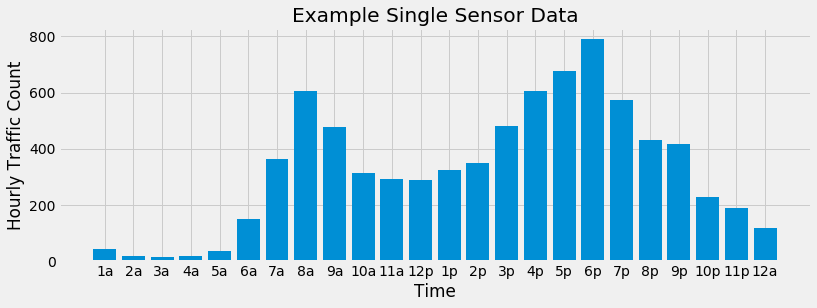

In [98]:
fig, ax = plt.subplots(figsize=(12,4))
ax.bar(df[time_cols].loc[0].index, df[time_cols].loc[0].to_numpy())
ax.set_ylabel('Hourly Traffic Count')
ax.set_xlabel('Time')
ax.set_title('Example Single Sensor Data')
plt.show()

## Single Time of Day Data

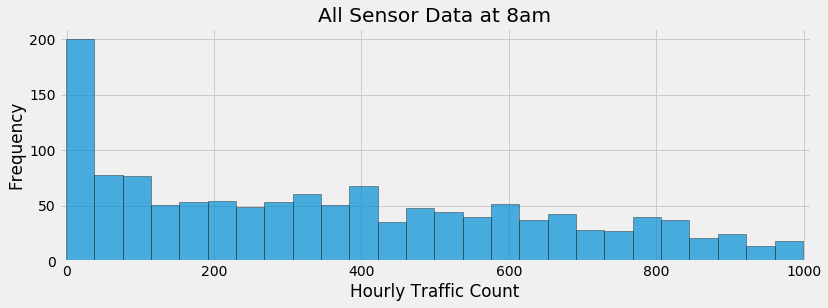

In [99]:
fig, ax = plt.subplots(figsize=(12,4))
time = '8a'
# sn.distplot(df[time], ax=ax, bins=25, kde=False)
ax.hist(df[time], bins=30,  alpha=0.7, histtype='bar', ec='black')
ax.set_xlabel('Hourly Traffic Count')
ax.set_ylabel('Frequency')
ax.set_title(f'All Sensor Data at {time}m')
ax.set_xlim(-10,1010)
plt.show()

## Spatial Plotting

In [330]:
def plot_on_map(long, lat, size=20, img=pitt, color='r'):
    fig, ax = plt.subplots(figsize = (8,7))
    im = ax.scatter(long, lat, alpha=1, c=color, s=size, cmap='jet_r', vmin=0, vmax=1400)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(pitt, zorder=0, extent = BBox, aspect= 'equal')
    ax.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])
    return fig, ax, im

### All Sensors

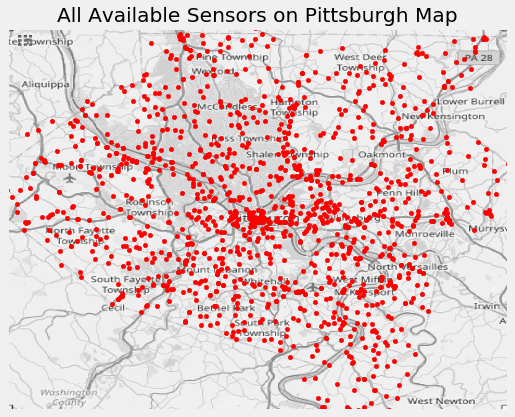

In [166]:
fig, ax, im = plot_on_map(df.Longitude, df.Latitude, img=pitt)
ax.set_title('All Available Sensors on Pittsburgh Map')
plt.show()

### Highly Trafficed Sensors

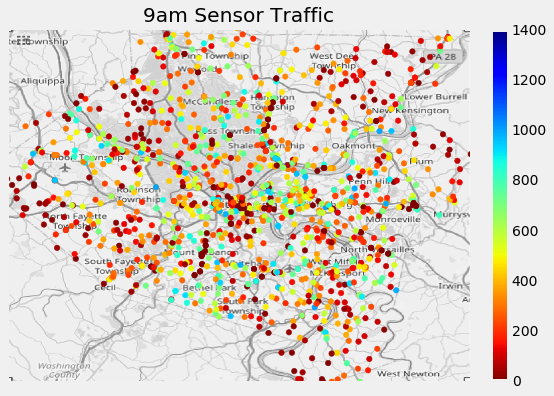

In [168]:
size = np.ones(df.Longitude.shape[0])*30
time='9a'
fig, ax, im = plot_on_map(df.Longitude, df.Latitude, size=size, img=pitt, color=df[time])
ax.set_title(f'{time}m Sensor Traffic')
fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
plt.show()

# Clustering Analysis

In [169]:
dim = df[['sensor_ID', 'Longitude', 'Latitude']]
X = df[time_cols] / df[time_cols].max().max()

## KNN

In [263]:
def plot_clusters(long, lat, size=20, img=pitt, color='r'):
    fig, ax = plt.subplots(figsize = (8,7))
    cmap = plt.get_cmap('jet_r', np.max(color)-np.min(color)+1)
    im = ax.scatter(df.Longitude, df.Latitude, alpha=1, c=color, s=size, cmap=cmap)
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    ax.imshow(pitt, zorder=0, extent = BBox, aspect= 'equal')
    ax.grid(False)
    ax.set_yticks([])
    ax.set_xticks([])
    return fig, ax, im

### First Fit

Final Inertia: 200.89

----- Cluster Counts -----
Cluster #1: 354
Cluster #2: 365
Cluster #3: 86
Cluster #4: 212
Cluster #5: 288
--------------------------


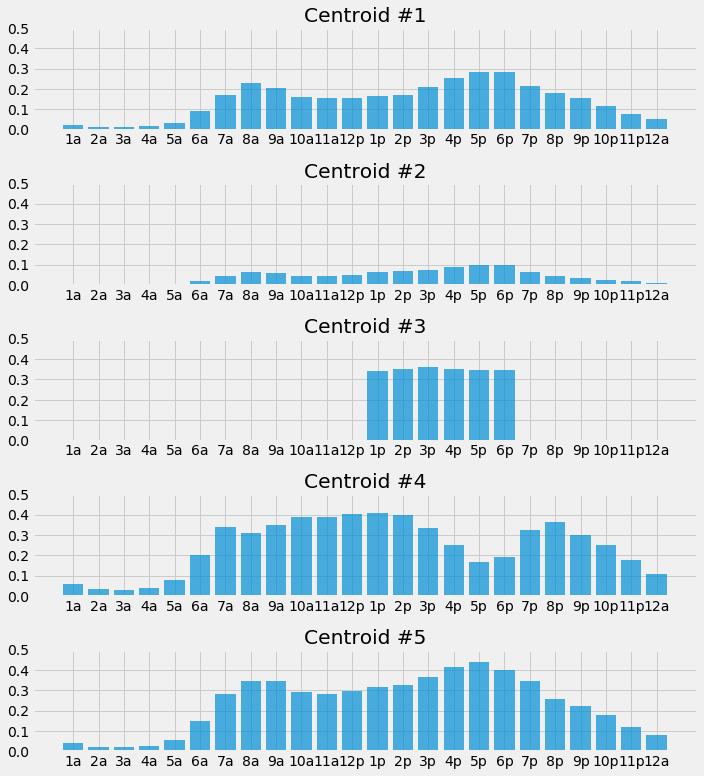

In [243]:
kmeans = KMeans(
    init="random",
    n_clusters=5,
    n_init=100,
    max_iter=300,
    random_state=42,
    verbose=0
)
kmeans.fit(X)
fig, ax = cluster.eval_knn_traffic(kmeans, time_cols, verbose=True, plot=True)

### Elbow Plot for Clusters

Elbow Clusters: 3
Final Inertia: 254.79

----- Cluster Counts -----
Cluster #1: 434
Cluster #2: 482
Cluster #3: 389
--------------------------


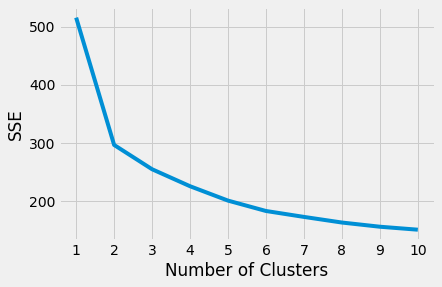

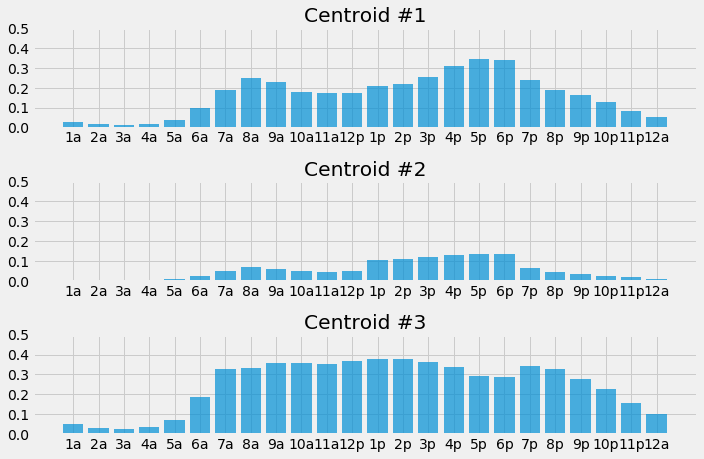

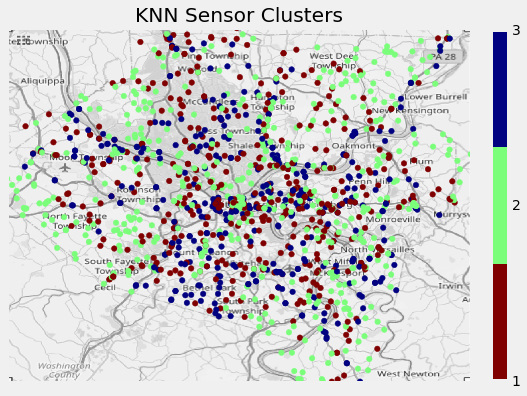

In [265]:
n_clusters = np.arange(10) + 1
sse = []
for k in n_clusters:
    kmeans = kmeans = KMeans(
                             init="random",
                             n_clusters=k,
                             n_init=100,
                             max_iter=300,
                             random_state=42,
                             verbose=0
                        )
    kmeans.fit(X)
    sse.append(kmeans.inertia_)
kl = cluster.knn_elbow(n_clusters, sse, plot=True, verbose=True)


kmeans = KMeans(
    init="random",
    n_clusters=kl.elbow,
    n_init=100,
    max_iter=300,
    random_state=42,
    verbose=0
)
kmeans.fit(X)
fig, ax = cluster.eval_knn_traffic(kmeans, time_cols, verbose=True, plot=True)

fig, ax, im = plot_clusters(df.Longitude, df.Latitude, size=30, img=pitt, color=kmeans.labels_+1)
ax.set_title('KNN Sensor Clusters')
cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_ticks([1,2,3])
plt.show()

### Sillhouette Coefficients

Final Inertia: 172.89

----- Cluster Counts -----
Cluster #1: 231
Cluster #2: 245
Cluster #3: 194
Cluster #4: 286
Cluster #5: 168
Cluster #6: 90
Cluster #7: 91
--------------------------


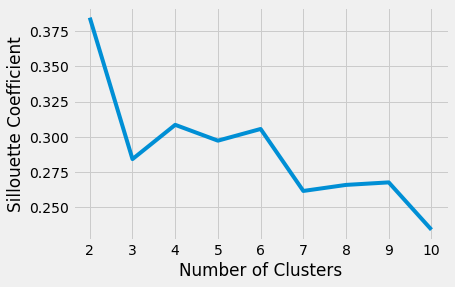

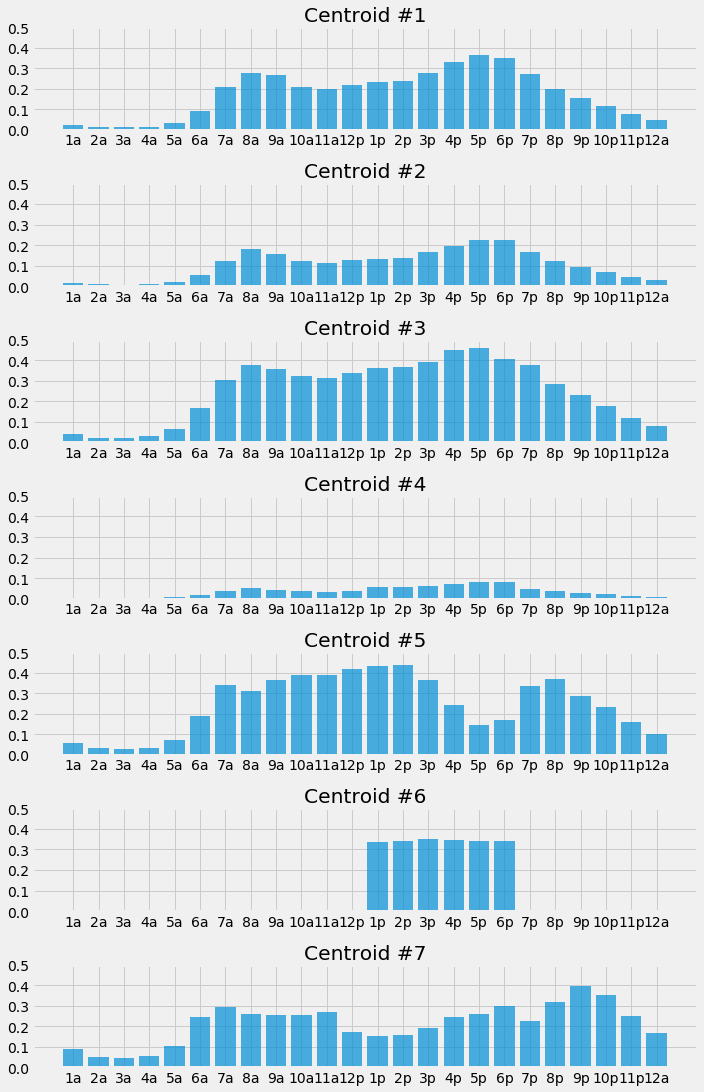

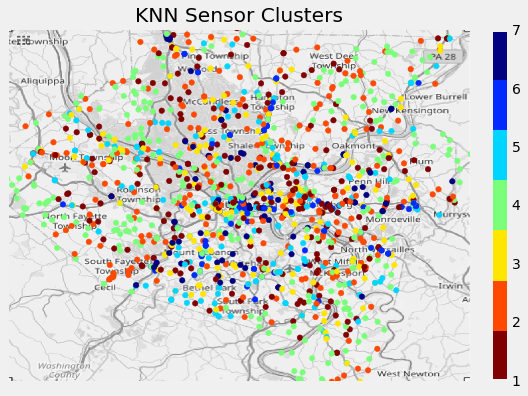

In [268]:
n_clusters = np.arange(9) + 2
sil = []
for k in n_clusters:
    kmeans = kmeans = KMeans(
                             init="random",
                             n_clusters=k,
                             n_init=100,
                             max_iter=300,
                             random_state=42,
                             verbose=0
                        )
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    sil.append(score)
cluster.knn_sillouette(n_clusters, sil, plot=True, verbose=True)

kmeans = KMeans(
    init="random",
    n_clusters=7,
    n_init=100,
    max_iter=300,
    random_state=42,
    verbose=0
)
kmeans.fit(X)
fig, ax = cluster.eval_knn_traffic(kmeans, time_cols, verbose=True, plot=True)

fig, ax, im = plot_clusters(df.Longitude, df.Latitude, size=30, img=pitt, color=kmeans.labels_+1)
ax.set_title('KNN Sensor Clusters')
cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_ticks(np.arange(7) + 1)
plt.show()

## DBSCAN

In [303]:
for i in np.linspace(0.05,0.5,5):
    print(f'EPS: {i:.2f}')
    dbscan = DBSCAN(eps=i, min_samples=5)
    dbscan.fit(X)
    dbscan_silhouette = silhouette_score(
       X, dbscan.labels_
    )
    print(pd.Series(dbscan.labels_).value_counts())
    print()

EPS: 0.05
-1    1136
 0     162
 1       7
dtype: int64

EPS: 0.16
 0    777
-1    505
 1      8
 4      5
 3      5
 2      5
dtype: int64

EPS: 0.28
 0    951
-1    314
 1     16
 3     13
 2      6
 4      5
dtype: int64

EPS: 0.39
 0    1027
-1     205
 3      27
 1      12
 2       7
 8       6
 7       6
 6       5
 5       5
 4       5
dtype: int64

EPS: 0.50
 0    1177
-1     110
 1       8
 3       5
 2       5
dtype: int64



DBSCAN clearly is not very well suited to this problem because of the dimensionality.

## Hierarchical Clustering

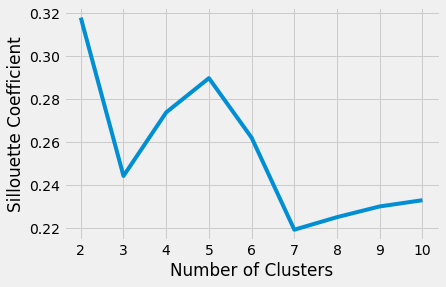

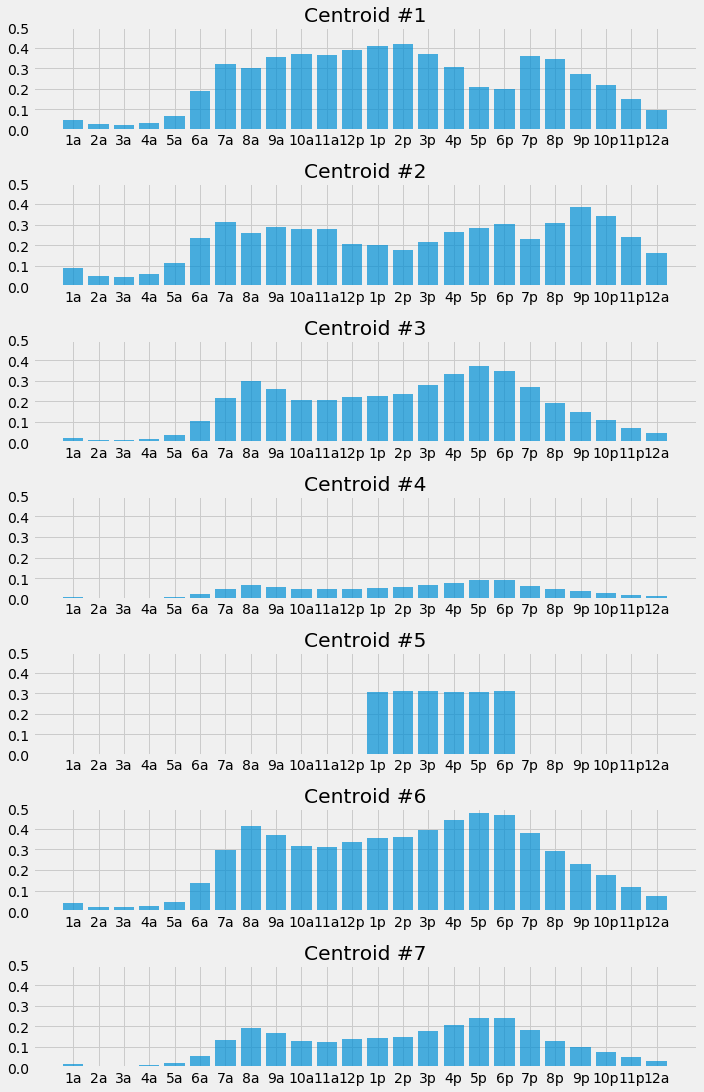

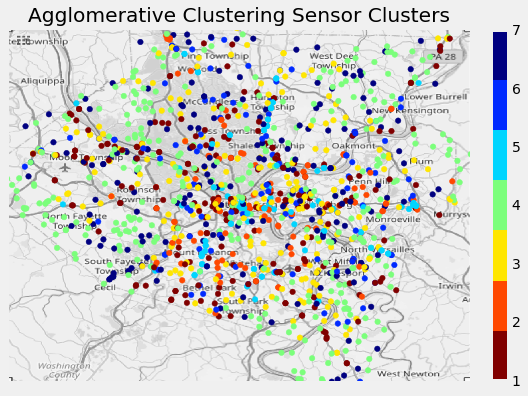

In [320]:
n_clusters = np.arange(9) + 2
sil = []
for k in n_clusters:
    AG = AgglomerativeClustering(n_clusters=k)
    AG.fit(X)
    score = silhouette_score(X, AG.labels_)
    sil.append(score)
cluster.knn_sillouette(n_clusters, sil, plot=True, verbose=True)

AG = AgglomerativeClustering(
    n_clusters=n_clusters[np.argmin(sil)])
AG.fit(X)

fig, ax = cluster.ag_plot_avg(X, AG, time_cols)

fig, ax, im = plot_clusters(df.Longitude, df.Latitude, size=30, img=pitt, color=AG.labels_+1)
ax.set_title('Agglomerative Clustering Sensor Clusters')
cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
cbar.set_ticks(np.arange(n_clusters[np.argmin(sil)])+1)
plt.show()

# Interpreting Results

In [323]:
df_res = df.copy()
df_res['ag_lab'] = AG.labels_
df_res['knn_lab'] = kmeans.labels_

## Indentifying Rush Hour Nightmares

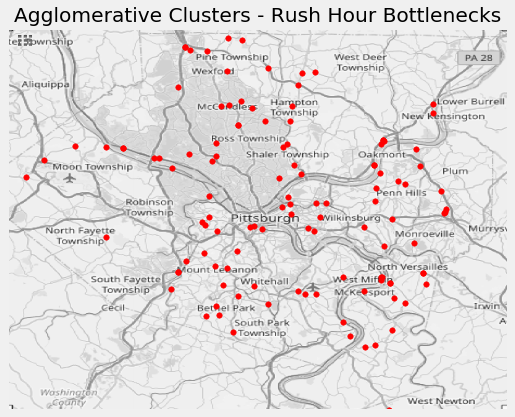

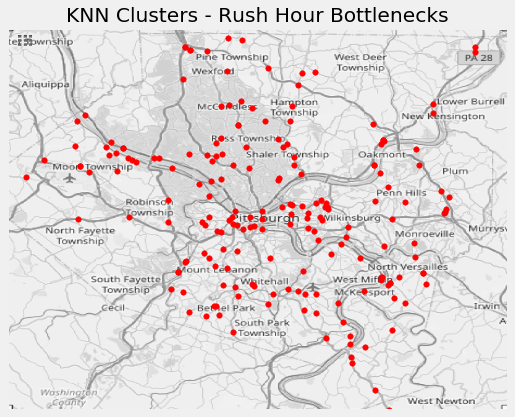

In [356]:
bad_ag = 5
bad_knn = 2
df_bot = df_res[df_res['ag_lab'] == bad_ag]
fig, ax, im = plot_on_map(df_bot.Longitude, df_bot.Latitude, 
                            size=30, img=pitt, color='r')
ax.set_title('Agglomerative Clusters - Rush Hour Bottlenecks')
plt.show()

df_bot = df_res[df_res['knn_lab'] == bad_knn]
fig, ax, im = plot_on_map(df_bot.Longitude, df_bot.Latitude, 
                            size=30, img=pitt, color='r')
ax.set_title('KNN Clusters - Rush Hour Bottlenecks')
plt.show()

Having lived in Pittsburgh before, the clustering algorithms extract interesting points around the Pittsburgh area that are not only on the free ways - consistent with my experience on the roads there.

## Missing Data Sensors

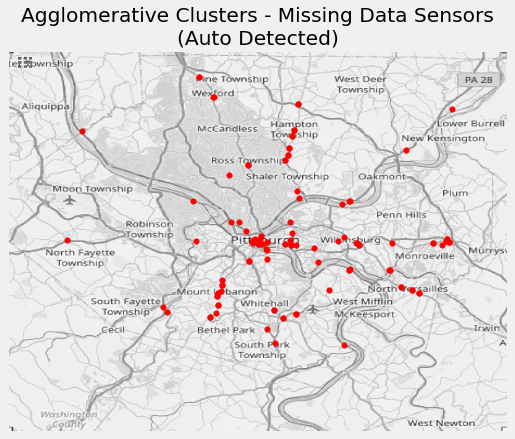

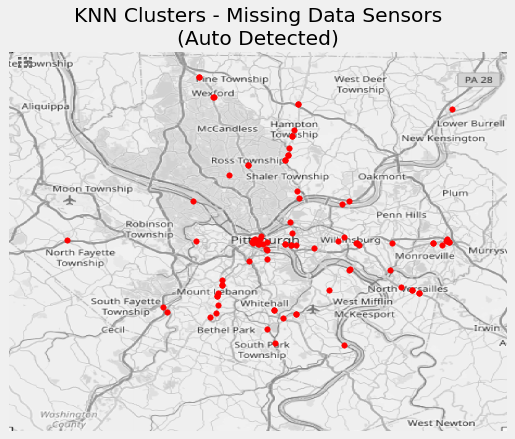

In [359]:
bad_ag = 4
bad_knn = 5
df_bot = df_res[df_res['ag_lab'] == bad_ag]
fig, ax, im = plot_on_map(df_bot.Longitude, df_bot.Latitude, 
                            size=30, img=pitt, color='r')
ax.set_title('Agglomerative Clusters - Missing Data Sensors\n(Auto Detected)')
plt.show()

df_bot = df_res[df_res['knn_lab'] == bad_knn]
fig, ax, im = plot_on_map(df_bot.Longitude, df_bot.Latitude, 
                            size=30, img=pitt, color='r')
ax.set_title('KNN Clusters - Missing Data Sensors\n(Auto Detected)')
plt.show()

## Low Traffic Areas

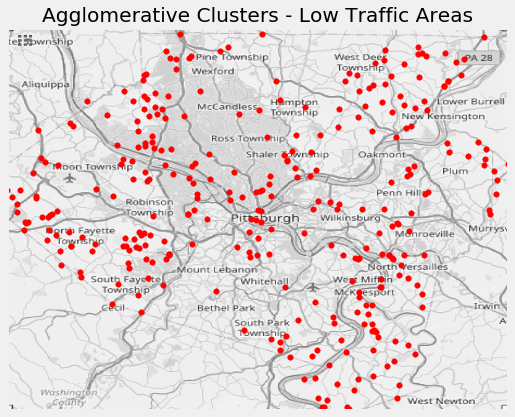

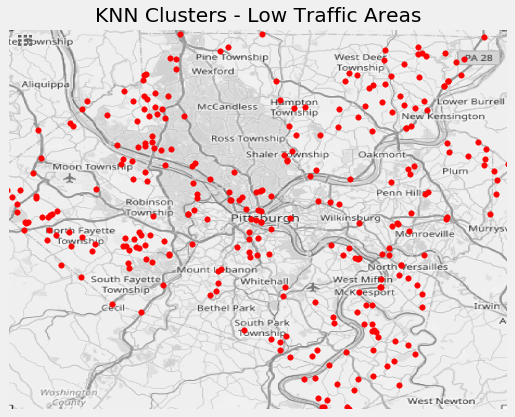

In [360]:
bad_ag = 3
bad_knn = 3
df_bot = df_res[df_res['ag_lab'] == bad_ag]
fig, ax, im = plot_on_map(df_bot.Longitude, df_bot.Latitude, 
                            size=30, img=pitt, color='r')
ax.set_title('Agglomerative Clusters - Low Traffic Areas')
plt.show()

df_bot = df_res[df_res['knn_lab'] == bad_knn]
fig, ax, im = plot_on_map(df_bot.Longitude, df_bot.Latitude, 
                            size=30, img=pitt, color='r')
ax.set_title('KNN Clusters - Low Traffic Areas')
plt.show()